In [1]:
import os
import sys
import time
import numpy as np
import pandas as pd
import sklearn
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import keras

In [2]:
from sklearn.datasets import fetch_california_housing

In [3]:
housing = fetch_california_housing()
print(housing.DESCR)
print(housing.data.shape)
print(housing.target.shape)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bur

### 数据集划分

In [4]:
from sklearn.model_selection import train_test_split
#默认训练集：测试集 =3 ：1 
x_train_all,x_test,y_train_all,y_test = train_test_split(housing.data,housing.target,random_state = 7,test_size = 0.25)
x_train,x_valid,y_train,y_valid = train_test_split(x_train_all,y_train_all,random_state = 11,test_size = 0.25)
print(x_train.shape,y_train.shape)
print(x_valid.shape,y_valid.shape)
print(x_test.shape,y_test.shape)

(11610, 8) (11610,)
(3870, 8) (3870,)
(5160, 8) (5160,)


### 数据归一化处理

In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_valid_scaled = scaler.transform(x_valid)
x_test_scaled  = scaler.transform(x_test)

### wide & deep 模型

In [6]:
# 函数式api 功能API
# input = tf.keras.layers.Input(shape = x_train_scaled.shape[1:])
# hidden1 = tf.keras.layers.Dense(30,activation = "relu")(input)
# hidden2 = tf.keras.layers.Dense(30,activation = "relu")(hidden1)
# concat = tf.keras.layers.concatenate([input,hidden2])
# output = tf.keras.layers.Dense(1)(concat)
# model = tf.keras.models.Model(inputs = [input],outputs=[output])

#子类API实现
# class WideDeepModel(tf.keras.models.Model):
#     def __init__(self):
#         super(WideDeepModel,self).__init__()
#         '''定义模型层次'''
#         self.hidden1_layer = tf.keras.layers.Dense(30,activation = "relu")
#         self.hidden2_layer = tf.keras.layers.Dense(30,activation = "relu")
#         self.output_layer = tf.keras.layers.Dense(1)
#     #python 中实例对象 model（input）就会调用call函数
#     def call(self,input):
#         '''定义模型的正向计算'''
#         hidden1 = self.hidden1_layer(input)
#         hidden2 = self.hidden2_layer(hidden1)
#         concat = tf.keras.layers.concatenate([input,hidden2])
#         output = self.output_layer(concat)
#         return output
# model = WideDeepModel() # 或者 model = tf.keras.models.Sequential([WideDeepModel(),])
# model.build(input_shape = (None,8))

#多输入和多输出
input_wide = tf.keras.layers.Input(shape=[5])
input_deep = tf.keras.layers.Input(shape=[6])
hidden1 = tf.keras.layers.Dense(30,activation = "relu")(input_deep)
hidden2 = tf.keras.layers.Dense(30,activation = "relu")(hidden1)
concat = tf.keras.layers.concatenate([input_wide,hidden2])
output1 = tf.keras.layers.Dense(1)(concat)
output2 = tf.keras.layers.Dense(1)(hidden2)

model = tf.keras.models.Model(inputs = [input_wide,input_deep],outputs=[output1,output2])

model.summary()
model.compile(loss="mean_squared_error",optimizer="Adam") #sgd随机梯度下降，mean_squared_error均方误差
callbacks = [tf.keras.callbacks.EarlyStopping(patience= 5,min_delta = 1e-3)]

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 6)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 30)           210         input_2[0][0]                    
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 5)]          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 30)           930         dense[0][0]                      
______________________________________________________________________________________________

In [7]:
#多输入
x_train_scaled_wide = x_train_scaled[:,0:5]
x_train_scaled_deep = x_train_scaled[:,2:]
x_valid_scaled_wide = x_valid_scaled[:,0:5]
x_valid_scaled_deep = x_valid_scaled[:,2:]
x_test_scaled_wide = x_test_scaled[:,0:5]
x_test_scaled_deep = x_test_scaled[:,2:]
history = model.fit([x_train_scaled_wide,x_train_scaled_deep],
                    [y_train,y_train],
                    validation_data=([x_valid_scaled_wide,x_valid_scaled_deep],[y_valid,y_valid]),
                    epochs=100,
                    callbacks=callbacks)

# history = model.fit(x_train_scaled,y_train,validation_data=(x_valid_scaled,y_valid),epochs=100,callbacks=callbacks)

Train on 11610 samples, validate on 3870 samples
Epoch 1/100
11610/11610 [==============================] - 2s 161us/sample - loss: 2.9612 - dense_2_loss: 1.5129 - dense_3_loss: 1.4472 - val_loss: 1.4492 - val_dense_2_loss: 0.7109 - val_dense_3_loss: 0.7380
Epoch 2/100
11610/11610 [==============================] - 1s 101us/sample - loss: 1.1931 - dense_2_loss: 0.5705 - dense_3_loss: 0.6226 - val_loss: 1.1221 - val_dense_2_loss: 0.5281 - val_dense_3_loss: 0.5938
Epoch 3/100
11610/11610 [==============================] - 1s 100us/sample - loss: 1.0106 - dense_2_loss: 0.4646 - dense_3_loss: 0.5460 - val_loss: 0.9785 - val_dense_2_loss: 0.4500 - val_dense_3_loss: 0.5284
Epoch 4/100
11610/11610 [==============================] - 1s 101us/sample - loss: 0.9103 - dense_2_loss: 0.4156 - dense_3_loss: 0.4946 - val_loss: 0.9130 - val_dense_2_loss: 0.4153 - val_dense_3_loss: 0.4976
Epoch 5/100
11610/11610 [==============================] - 1s 104us/sample - loss: 0.8593 - dense_2_loss: 0.3937 - 

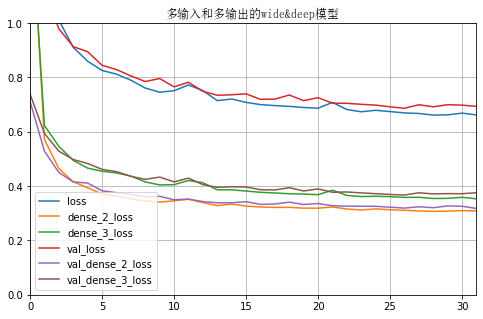

5160/5160 [==============================] - 0s 50us/sample - loss: 0.6926 - dense_2_loss: 0.3241 - dense_3_loss: 0.3711


[0.6926319360733032, 0.32410392, 0.371099]

In [8]:
def plot_learning_curves_with_title(history,img_title):
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.grid(True)
    plt.gca().set_ylim(0,1)
    from matplotlib.font_manager import FontProperties
    font_set= FontProperties(fname=r"c:\windows\fonts\simsun.ttc",size=12)
    plt.title(img_title,fontProperties = font_set)
    plt.show()
plot_learning_curves_with_title(history,"多输入和多输出的wide&deep模型")
model.evaluate([x_test_scaled_wide,x_test_scaled_deep],[y_test,y_test])